# Gradient-descent based optimization

The goal of this chapter is to provide a quick overview of gradient descent 
based optimization and how it interacts with deep source separation models. 
Gradient descent is how nearly all modern deep nets are trained. 
Many more in-depth resources exist out there, as this chapter will only
scratch the surface. The learning outcomes of this chapter are:

1. Understand at a high-level what gradient descent is doing and how it works.
2. Understand and be able to choose between different optimization algorithms.
3. Be able to investigate various aspects of the learning process for debugging,
   diagnosing issues in your training scripts, or intellectual curiosity.
   
First, let's set up a simple example through which we can investigate 
gradient descent. Let's learn a simple linear regression. There are more
straightforward ways to learn linear regression, but for the sake of 
pedagogy, we'll start with this simple problem. We'll use PyTorch as our
ML library for this.

## Simple example: linear regression

In [36]:
import torch
from torch import nn
import nussl
import numpy as np
import matplotlib.pyplot as plt
import gif
from IPython import display
import tempfile

nussl.utils.seed(0)
to_numpy = lambda x: x.detach().numpy()
to_tensor = lambda x: torch.from_numpy(x).reshape(-1, 1).float()

def show_gif(path):
    with open(path,'rb') as f:
        display.display(display.Image(data=f.read(), format='png'))

Let's make a single layer neural network with 1 hidden unit. This 
is just a line, and corresponds to:

$$y = mx + b$$

where $y$ is the output of the network, and $m$ and $b$ are 
learnable parameters.

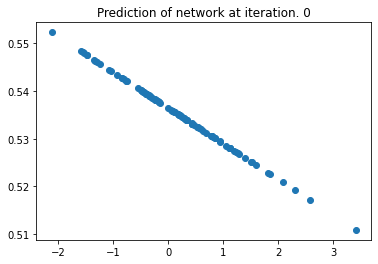

In [2]:
class Line(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(1, 1)

    def forward(self, x):
        y = self.layer(x)
        return y
    
line = Line()
x = torch.randn(100, 1)
y = line(x)

plt.title("Prediction of network at iteration. 0")
plt.scatter(to_numpy(x), to_numpy(y))
plt.show()

The network is randomly initialized, and we passed some random data through it.
Since it's a single linear layer with one unit, we can see that it is a line.
The magic is hidden away inside the `nn.Linear` call. PyTorch initializes
a single network layer with one hidden unit ($m$) and a bias ($b$):

In [3]:
for n, p in line.named_parameters():
    print(n, p)

layer.weight Parameter containing:
tensor([[-0.0075]], requires_grad=True)
layer.bias Parameter containing:
tensor([0.5364], requires_grad=True)


`layer.weight` corresponds to $m$ and `layer.bias` corresponds to $b$. Note
the way we are iterating over the parameters in the network - that'll be
important later on!

Now that we've got our simple model, let's make some training data. The training
data here will be a line of some slope with some bias, plus a bit of random 
noise with a mean of $0$ and standard deviation $\sigma$. In math, it's like this:

$$y = mx + b + \mathcal{N}(0, \sigma)$$

We will try to recover $m$ and $b$ as close as possible via gradient
descent. Okay, let's make the data:

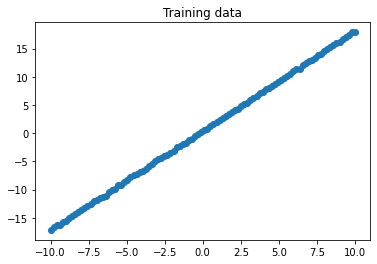

In [4]:
m = np.random.randn()
b = np.random.randn()
x = np.linspace(-10, 10, 100)
noise = np.random.normal(loc=0, scale=0.1, size=100)

y = m*x + b + noise

plt.title("Training data")
plt.scatter(x, y)
plt.show()

Let's look at what our network does on this data, overlaid with the actual training data:

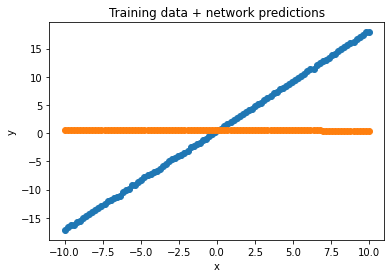

In [5]:
y_hat = line(to_tensor(x))

plt.title("Training data + network predictions")
plt.scatter(x, y, label='Training data')
plt.scatter(x, to_numpy(y_hat), label='Network predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Let's now take a look at how gradient descent can be used to learn $m$ and $b$
directly from the training data. The first thing we need is a way to tell how
well the network is doing right now. That is to say, how accurate are its predictions?
To do this, we need a loss function. A very simple one would just be to take the
absolute difference between the predictions and the ground truth:

$$L(x, y; \theta) = |\theta(x) - y|^1_1$$

where $\theta$ is our neural network function, which does the following operation:

$$ \theta(x) = \hat{m}x + \hat{b} $$

where $\hat{m}$ and $\hat{b}$ are the current parameters of the network. 

So, how's our network doing?

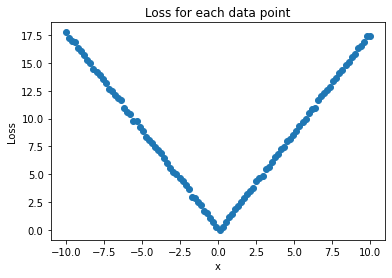

In [6]:
loss = (y_hat - to_tensor(y)).abs()
plt.title("Loss for each data point")
plt.scatter(x, to_numpy(loss))
plt.ylabel("Loss")
plt.xlabel("x")
plt.show()

Above you can see the loss for every point in our training data. But in order to
do the next step, we will need to represent the performance of the network as a 
single number. To do this, we'll just take the mean:

In [7]:
loss.mean()

tensor(8.9430, grad_fn=<MeanBackward0>)

Why the mean and not the sum or some other aggregator? Well, the mean is nice because
it stays in the same range no matter how many data points you compute the loss over, 
unlike the sum. Second, we want to increase the performance across the board, so we wouldn't want
to use max or some operation that only looks at one data point.

Now that we've got a measure of how well our network is doing, how do we make the
network better? The goal is to reduce the loss. Let's do this in a really naive way
first: let's guess! We'll do a search over all the possible network parameters for our
Line module within some range, and compute the loss for each one:

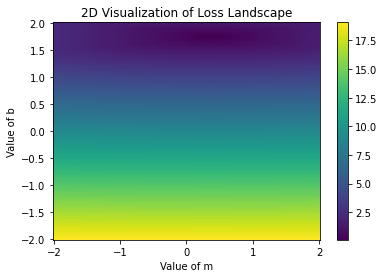

In [8]:
possible_m = np.linspace(-2, 2, 100)
possible_b = np.linspace(-2, 2, 100)
loss = np.empty((
    possible_m.shape[0], 
    possible_b.shape[0]
))

for i, m_hat in enumerate(possible_m):
    for j, b_hat in enumerate(possible_b):
        line.layer.weight[0, 0] = m_hat
        line.layer.bias[0] = b_hat
        y_hat = line(to_tensor(x))
        _loss = (y_hat - to_tensor(y)).abs().mean()
        loss[i, j] = _loss

plt.title('2D Visualization of Loss Landscape')
plt.pcolormesh(possible_m, possible_b, loss, shading='auto')
plt.colorbar()
plt.xlabel('Value of m')
plt.ylabel('Value of b')
plt.show()

What we did: iterate over all values of $m$ and $b$ above and compute the loss.
Then, we plotted the loss in a 2D visualization. We can see the dark blue part of
the image, which indicates where the loss is minimized. Let's see what the actual
value is:

In [9]:
idx = np.unravel_index(np.argmin(loss, axis=None), loss.shape)
m_hat = possible_m[idx[0]]
b_hat = possible_b[idx[1]]

print(f"Loss minimum of {loss.min():-2f} at \n\t m_hat={m_hat:0.2f}, b_hat={b_hat:-.2f}")
print(f"Actual m, b: \n\t m={m:.2f}, b={b:.2f}")

Loss minimum of 0.086866 at 
	 m_hat=1.76, b_hat=0.38
Actual m, b: 
	 m=1.76, b=0.40


Here's what the network predictions look like, with the learned line:

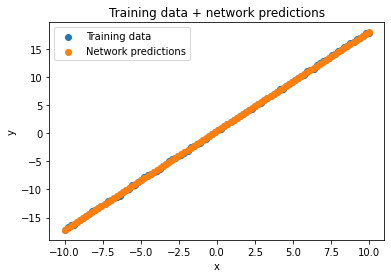

In [10]:
line.layer.weight[0, 0] = m_hat
line.layer.bias[0] = b_hat

y_hat = line(to_tensor(x))

plt.title("Training data + network predictions")
plt.scatter(x, y, label='Training data')
plt.scatter(x, to_numpy(y_hat), label='Network predictions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Iterating over all possible $m$ and $b$ values in a range worked here, but it's not a great
thing in general. We only have $2$ parameters here, and we did $100$ choices for each, so that worked
out to $100 * 100$ = 10k "iterations" to learn a line! How do we cut this down? By using
gradient descent, of course.

In gradient descent, we look at the local loss landscape - where we are now and the points that we
could go to around us. To make things simpler, let's use the data we generated above to look
at how the loss changes as the value of $m$ changes:

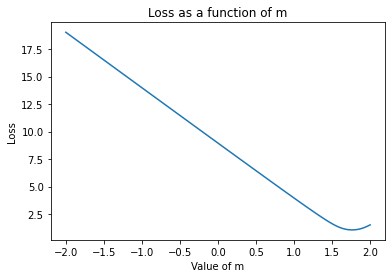

In [11]:
plt.plot(possible_m, loss.mean(axis=1))
plt.xlabel('Value of m')
plt.ylabel('Loss')
plt.title('Loss as a function of m')
plt.show()

Now, let's look at it as $b$ changes:

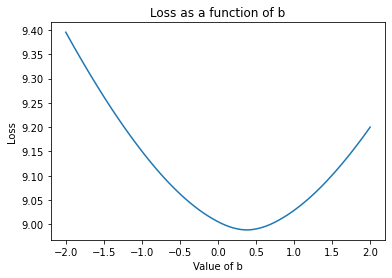

In [12]:
plt.plot(possible_b, loss.mean(axis=0))
plt.xlabel('Value of b')
plt.ylabel('Loss')
plt.title('Loss as a function of b')
plt.show()

The slope of these curves is the gradient. For example, in the first $m$ plot, we 
see the loss goes down as $m$ increases from $-1$ to $-.75$ roughly linearly. The
gradient between these points is simply the change in the loss with respect to $m$
as you change it from $-1$ to $-.75$: about $-1$. By using the gradient to continue 
in the direction that makes the loss go down, we are doing gradient descent. Note that
at the minima - where the loss is lowest, the gradient is $0$.

PyTorch has an easy way of computing gradients: the `backward()` function. To compute
the gradients, just compute the loss and then call `backward()` on it.

In [13]:
line = Line()
with torch.no_grad():
    line.layer.weight[0, 0] = m_hat
    line.layer.bias[0] = b_hat

y_hat = line(to_tensor(x))
_loss = (y_hat - to_tensor(y)).abs().mean()
_loss.backward()

line.layer.weight.grad, line.layer.bias.grad

(tensor([[-0.8747]]), tensor([-0.1000]))

So the weight has a gradient flowing through it, as does the bias. Let's do the same thing we
did for the loss before, but this time let's look at the gradients as $m$ and $b$ change:

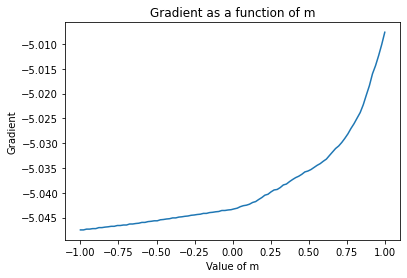

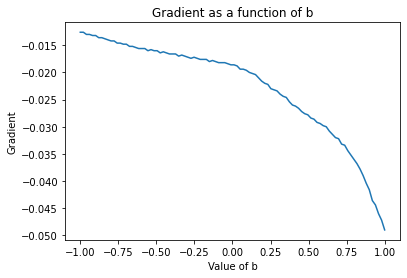

In [14]:
possible_m = np.linspace(-1, 1, 100)
possible_b = np.linspace(-1, 1, 100)
grad_m = np.empty((
    possible_m.shape[0], 
    possible_b.shape[0]
))
grad_b = np.empty((
    possible_m.shape[0], 
    possible_b.shape[0]
))

for i, m_hat in enumerate(possible_m):
    for j, b_hat in enumerate(possible_b):
        line = Line()
        with torch.no_grad():
            line.layer.weight[0, 0] = m_hat
            line.layer.bias[0] = b_hat
        y_hat = line(to_tensor(x))
        _loss = (y_hat - to_tensor(y)).abs().mean()
        _loss.backward()
        
        grad_m[i, j] = line.layer.weight.grad.item()
        grad_b[i, j] = line.layer.bias.grad.item()

plt.plot(possible_m, grad_m.mean(axis=1))
plt.xlabel('Value of m')
plt.ylabel('Gradient')
plt.title('Gradient as a function of m')
plt.show()

plt.plot(possible_b, grad_b.mean(axis=1))
plt.xlabel('Value of b')
plt.ylabel('Gradient')
plt.title('Gradient as a function of b')
plt.show()

Above we can see that at each value of $m$ or $b$ the gradient tells
us which way will *increase* the loss. Below the optimal value of $\hat{m}$,
it's telling us that decreasing $\hat{m}$ will *increase* the loss. So therefore, we
must go in the *opposite* direction of the gradient. Let's put it all together:

1. Compute the gradient for the current network parameters $\hat{m}$ and $\hat{b}$.
2. Go in the opposite direction of the gradient by some fixed amount.
3. Go back to 1.

In a simple for loop, it looks like this:

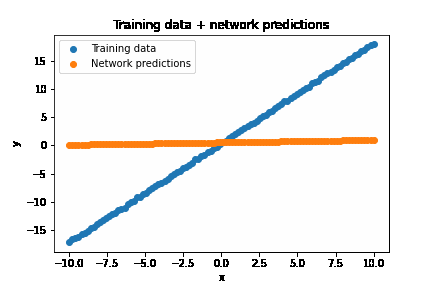

In [38]:
N_ITER=100
LEARNING_RATE = 0.01
# initialize line
line = Line()

frames = []
@gif.frame
def plot(i):
    plt.figure()
    y_hat = line(to_tensor(x))

    plt.title("Training data + network predictions")
    plt.scatter(x, y, label='Training data')
    plt.scatter(x, to_numpy(y_hat), label='Network predictions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

for i in range(N_ITER):
    line.zero_grad()
    y_hat = line(to_tensor(x))
    _loss = (y_hat - to_tensor(y)).abs().mean()
    _loss.backward()
    
    for n, p in line.named_parameters():
        p.data += - LEARNING_RATE * p.grad
    
    frame = plot(i)
    frames.append(frame)

with tempfile.NamedTemporaryFile(suffix='.gif') as f:
    gif.save(frames, f.name, duration=3.5, unit="s", between="startend")
    show_gif(f.name)

## Tracking key metrics during training

## Beyond SGD: Momentum and friends

## Gradient Clipping